<a href="https://colab.research.google.com/github/Freesoul-tech/Louis-Mahobe/blob/main/comv_2d_rev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
class Conv2d:
    def __init__(self, in_channels, out_channels, kernel_size):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.01
        self.bias = np.zeros(out_channels)

    def forward(self, x):
        self.x = x  # Save input for backward
        batch_size, _, H, W = x.shape
        k = self.kernel_size
        H_out = H - k + 1
        W_out = W - k + 1
        out = np.zeros((batch_size, self.out_channels, H_out, W_out))

        for b in range(batch_size):
            for oc in range(self.out_channels):
                for i in range(H_out):
                    for j in range(W_out):
                        patch = x[b, :, i:i+k, j:j+k]
                        out[b, oc, i, j] = np.sum(patch * self.weights[oc]) + self.bias[oc]
        return out

    def backward(self, delta):
        x = self.x
        batch_size, _, H, W = x.shape
        k = self.kernel_size
        H_out = H - k + 1
        W_out = W - k + 1

        dw = np.zeros_like(self.weights)
        db = np.zeros_like(self.bias)
        dx = np.zeros_like(x)

        for b in range(batch_size):
            for oc in range(self.out_channels):
                db[oc] += np.sum(delta[b, oc])
                for ic in range(self.in_channels):
                    for i in range(H_out):
                        for j in range(W_out):
                            patch = x[b, ic, i:i+k, j:j+k]
                            dw[oc, ic] += delta[b, oc, i, j] * patch
                            dx[b, ic, i:i+k, j:j+k] += delta[b, oc, i, j] * self.weights[oc, ic]
        return dx, dw, db


In [44]:
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]])

w = np.array([[[[ 0.,  0.,  0.],
                [ 0.,  1.,  0.],
                [ 0., -1.,  0.]]],

              [[[ 0.,  0.,  0.],
                [ 0., -1.,  1.],
                [ 0.,  0.,  0.]]]])

conv = Conv2d(in_channels=1, out_channels=2, kernel_size=3)
conv.weights = w
conv.bias = np.zeros(2)

out = conv.forward(x)
print(out)


[[[[-4. -4.]
   [-4. -4.]]

  [[ 1.  1.]
   [ 1.  1.]]]]


In [45]:
def conv2d_output_size(H_in, W_in, F_h, F_w, P_h, P_w, S_h, S_w):
    H_out = (H_in + 2 * P_h - F_h) // S_h + 1
    W_out = (W_in + 2 * P_w - F_w) // S_w + 1
    return H_out, W_out


In [46]:
# Input: 28x28, Filter: 3x3, Padding: 1, Stride: 1
H_out, W_out = conv2d_output_size(28, 28, 3, 3, 1, 1, 1, 1)
print(f"Output size: {H_out} x {W_out}")


Output size: 28 x 28


In [55]:
import numpy as np

class MaxPool2D:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        self.x = x  # Save input for backward
        batch_size, channels, H, W = x.shape
        k = self.kernel_size
        s = self.stride
        H_out = (H - k) // s + 1
        W_out = (W - k) // s + 1
        out = np.zeros((batch_size, channels, H_out, W_out))
        # Store the indices of the maximum values for backward pass
        self.max_indices = np.zeros_like(x, dtype=bool)

        for b in range(batch_size):
            for c in range(channels):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * s
                        w_start = j * s
                        patch = x[b, c, h_start:h_start+k, w_start:w_start+k]
                        max_val = np.max(patch)
                        out[b, c, i, j] = max_val
                        # Create a mask for the max values in the patch
                        max_mask = (patch == max_val)
                        # Store the mask in the corresponding location in max_indices
                        self.max_indices[b, c, h_start:h_start+k, w_start:w_start+k] = max_mask
        return out

    def backward(self, delta):
        # Initialize dx with zeros
        dx = np.zeros_like(self.x)
        k = self.kernel_size
        s = self.stride
        batch_size, channels, H_out, W_out = delta.shape

        # Distribute the gradient delta to the max locations
        for b in range(batch_size):
            for c in range(channels):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * s
                        w_start = j * s
                        # Get the mask for the max locations in the original patch area
                        mask = self.max_indices[b, c, h_start:h_start+k, w_start:w_start+k]
                        # Add the incoming gradient delta[b, c, i, j] to the max locations in dx
                        dx[b, c, h_start:h_start+k, w_start:w_start+k] += delta[b, c, i, j] * mask
        return dx

In [48]:
x = np.array([[[[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9,10,11,12],
                [13,14,15,16]]]])

pool = MaxPool2D(kernel_size=2, stride=2)
out = pool.forward(x)
print("Forward output:\n", out)

delta = np.array([[[[1, 2],
                    [3, 4]]]])
dx = pool.backward(delta)
print("Backward output (∂L/∂x):\n", dx)


Forward output:
 [[[[ 6.  8.]
   [14. 16.]]]]
Backward output (∂L/∂x):
 [[[[0 0 0 0]
   [0 1 0 2]
   [0 0 0 0]
   [0 3 0 4]]]]


In [49]:
import numpy as np

class AveragePool2D:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        self.x = x
        batch_size, channels, H, W = x.shape
        k = self.kernel_size
        s = self.stride
        H_out = (H - k) // s + 1
        W_out = (W - k) // s + 1
        out = np.zeros((batch_size, channels, H_out, W_out))

        for b in range(batch_size):
            for c in range(channels):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * s
                        w_start = j * s
                        patch = x[b, c, h_start:h_start+k, w_start:w_start+k]
                        out[b, c, i, j] = np.mean(patch)
        return out

    def backward(self, delta):
        # Initialize dx with a float type to avoid UFuncTypeError
        dx = np.zeros_like(self.x, dtype=np.float64)
        k = self.kernel_size
        s = self.stride
        batch_size, channels, H_out, W_out = delta.shape
        scale = 1.0 / (k * k)

        for b in range(batch_size):
            for c in range(channels):
                for i in range(H_out):
                    for j in range(W_out):
                        h_start = i * s
                        w_start = j * s
                        dx[b, c, h_start:h_start+k, w_start:w_start+k] += delta[b, c, i, j] * scale
        return dx

In [51]:
x = np.array([[[[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9,10,11,12],
                [13,14,15,16]]]])

pool = AveragePool2D(kernel_size=2, stride=2)
out = pool.forward(x)
print("Forward output:\n", out)

delta = np.array([[[[1, 2],
                    [3, 4]]]])
dx = pool.backward(delta)
print("Backward output (∂L/∂x):\n", dx)


Forward output:
 [[[[ 3.5  5.5]
   [11.5 13.5]]]]
Backward output (∂L/∂x):
 [[[[0.25 0.25 0.5  0.5 ]
   [0.25 0.25 0.5  0.5 ]
   [0.75 0.75 1.   1.  ]
   [0.75 0.75 1.   1.  ]]]]


In [57]:
import numpy as np

class Flatten:
    def forward(self, x):
        self.original_shape = x.shape
        batch_size = x.shape[0]
        return x.reshape(batch_size, -1)

    def backward(self, delta):

        return delta.reshape(self.original_shape)

In [53]:
# Input: shape (1, 2, 2, 2)
x = np.array([[[[1, 2],
                [3, 4]],
               [[5, 6],
                [7, 8]]]])

flatten = Flatten()
out = flatten.forward(x)
print("Forward output:\n", out)


delta = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]])
dx = flatten.backward(delta)
print("Backward output (∂L/∂x):\n", dx)


Forward output:
 [[1 2 3 4 5 6 7 8]]
Backward output (∂L/∂x):
 [[[[0.1 0.2]
   [0.3 0.4]]

  [[0.5 0.6]
   [0.7 0.8]]]]


In [68]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split



# Load MNIST
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.values.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0
y = mnist.target.astype(np.int64)

# One-hot encoding
def one_hot(y, num_classes=10):
    # Ensure y is a numpy array for indexing
    y_array = y.values if isinstance(y, pd.Series) else y
    return np.eye(num_classes)[y_array]


# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Initialize layers
conv = Conv2d(in_channels=1, out_channels=4, kernel_size=3)
pool = MaxPool2D(kernel_size=2, stride=2)
flatten = Flatten()

class FC:
    def __init__(self, in_features, out_features):
        self.W = np.random.randn(in_features, out_features) * 0.01
        self.b = np.zeros(out_features)

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, delta, lr=0.01):
        dW = self.x.T @ delta
        db = np.sum(delta, axis=0)
        dx = delta @ self.W.T
        self.W -= lr * dW
        self.b -= lr * db
        return dx

fc = FC(in_features=4 * 13 * 13, out_features=10)  # After conv+pool

# Softmax + Cross-Entropy
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy(pred, target):
    # Ensure target is an array of integers
    target_indices = target.values if isinstance(target, pd.Series) else target
    return -np.mean(np.log(pred[np.arange(len(target_indices)), target_indices] + 1e-9))


# Training loop
for i in range(100):  # 100 samples for quick test
    x_batch = X_train[i:i+1]
    y_batch = y_train[i:i+1]

    # Forward
    out = conv.forward(x_batch)
    out = pool.forward(out)
    out = flatten.forward(out)
    out = fc.forward(out)
    probs = softmax(out)

    # Loss
    loss = cross_entropy(probs, y_batch)

    # Backward
    # Correct gradient for Softmax + Cross-Entropy
    delta = probs - one_hot(y_batch, num_classes=10)

    delta = fc.backward(delta)
    delta = flatten.backward(delta)
    delta = pool.backward(delta)
    _, dw, db = conv.backward(delta)
    conv.weights -= 0.01 * dw
    conv.bias -= 0.01 * db

    if i % 10 == 0:
        print(f"Step {i}, Loss: {loss:.4f}")

# Accuracy on test set
correct = 0
for i in range(100):  # quick test on 100 samples
    x = X_test[i:i+1]

    y = y_test.iloc[i]
    out = conv.forward(x)
    out = pool.forward(out)
    out = flatten.forward(out)
    out = fc.forward(out)
    probs = softmax(out)
    pred = np.argmax(probs)
    correct += (pred == y)

print(f"Accuracy: {correct}/100 = {correct / 100:.2f}")

Step 0, Loss: 2.3039
Step 10, Loss: 2.3017
Step 20, Loss: 2.3216
Step 30, Loss: 2.2941
Step 40, Loss: 2.2305
Step 50, Loss: 2.3231
Step 60, Loss: 2.4035
Step 70, Loss: 2.3851
Step 80, Loss: 2.2952
Step 90, Loss: 2.2925
Accuracy: 9/100 = 0.09


In [73]:


# Define LeNet layers
conv1 = Conv2d(in_channels=1, out_channels=6, kernel_size=5)
pool1 = MaxPool2D(kernel_size=2, stride=2)
conv2 = Conv2d(in_channels=6, out_channels=16, kernel_size=5)
pool2 = MaxPool2D(kernel_size=2, stride=2)
flatten = Flatten()
fc1 = FC(in_features=16*4*4, out_features=120)
fc2 = FC(in_features=120, out_features=84)
fc3 = FC(in_features=84, out_features=10)

# Training loop
for epoch in range(1):
    for i in range(100):
        x = X_train[i:i+1]
        y = y_train[i:i+1]

        # Forward pass
        out = conv1.forward(x)
        out = pool1.forward(out)
        out = conv2.forward(out)
        out = pool2.forward(out)
        out = flatten.forward(out)
        out = fc1.forward(out)
        out = fc2.forward(out)
        out = fc3.forward(out)
        probs = softmax(out)

        # Loss and backward
        loss = cross_entropy(probs, y)
        delta = probs

        delta[0, y.iloc[0]] -= 1
        delta = fc3.backward(delta)
        delta = fc2.backward(delta)
        delta = fc1.backward(delta)
        delta = flatten.backward(delta)
        delta = pool2.backward(delta)

        delta = conv2.backward(delta)[0]
        delta = pool1.backward(delta)

        delta = conv1.backward(delta)[0]

# Accuracy check
correct = 0
for i in range(100):
    x = X_test[i:i+1]
    y = y_test.iloc[i]
    out = conv1.forward(x)
    out = pool1.forward(out)
    out = conv2.forward(out)
    out = pool2.forward(out)
    out = flatten.forward(out)
    out = fc1.forward(out)
    out = fc2.forward(out)
    out = fc3.forward(out)
    probs = softmax(out)
    pred = np.argmax(probs)
    correct += (pred == y)

print(f"LeNet Accuracy on 100 test samples: {correct}/100 = {correct / 100:.2f}")

LeNet Accuracy on 100 test samples: 9/100 = 0.09


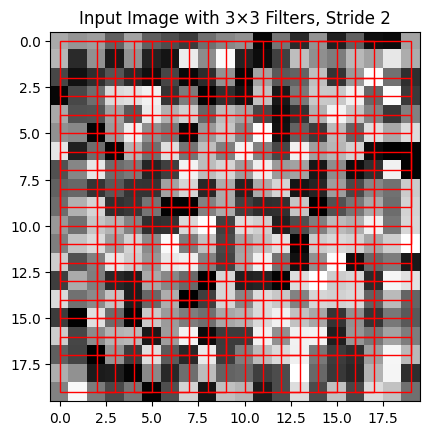

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate a single-channel input for clarity
input_image = np.random.rand(20, 20)

# Define filter and stride
filter_size = 3
stride = 2

# Compute output size
output_size = (input_image.shape[0] - filter_size) // stride + 1  # = 9

# Visualize patches
fig, ax = plt.subplots()
ax.imshow(input_image, cmap='gray')
ax.set_title("Input Image with 3×3 Filters, Stride 2")

# Overlay filter patches
for i in range(output_size):
    for j in range(output_size):
        y = i * stride
        x = j * stride
        rect = plt.Rectangle((x, y), filter_size, filter_size, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

plt.show()


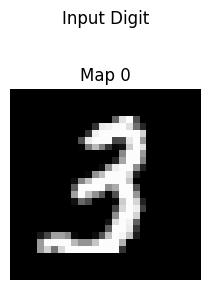

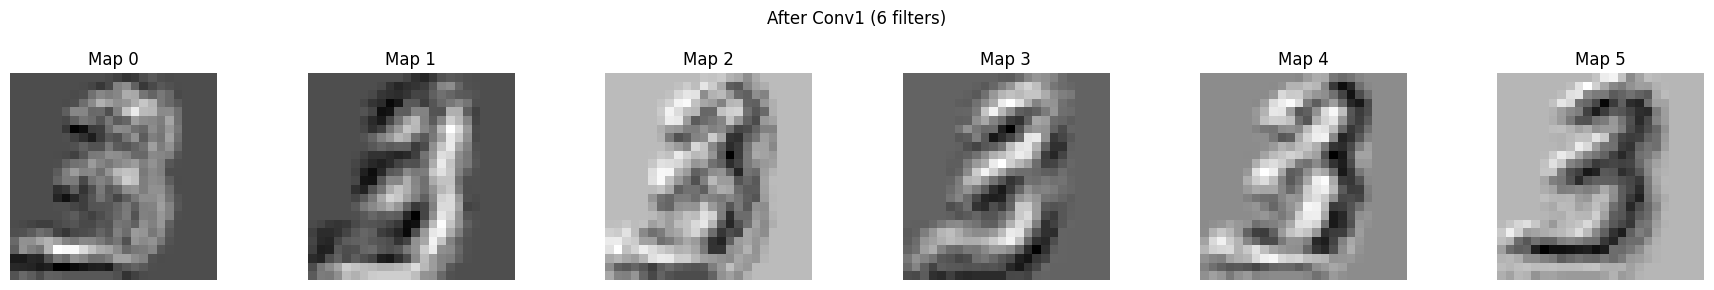

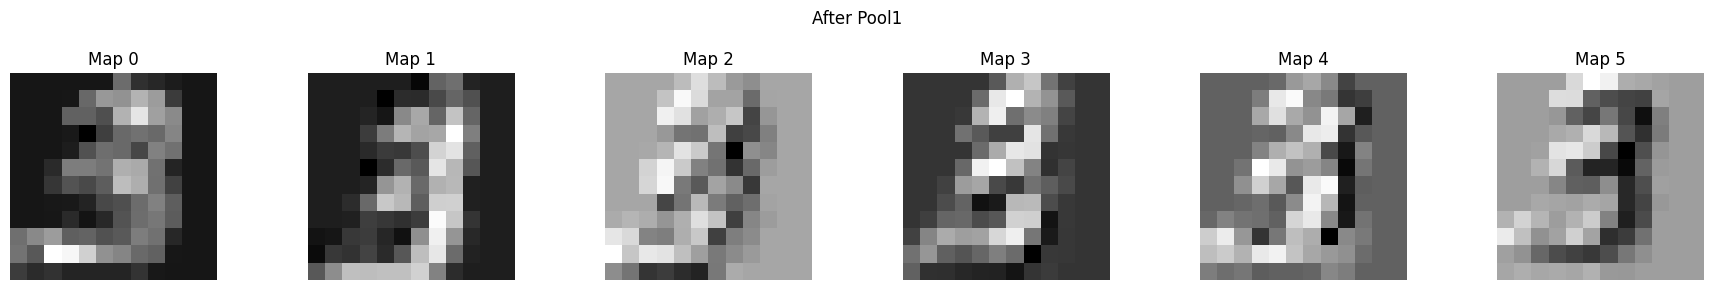

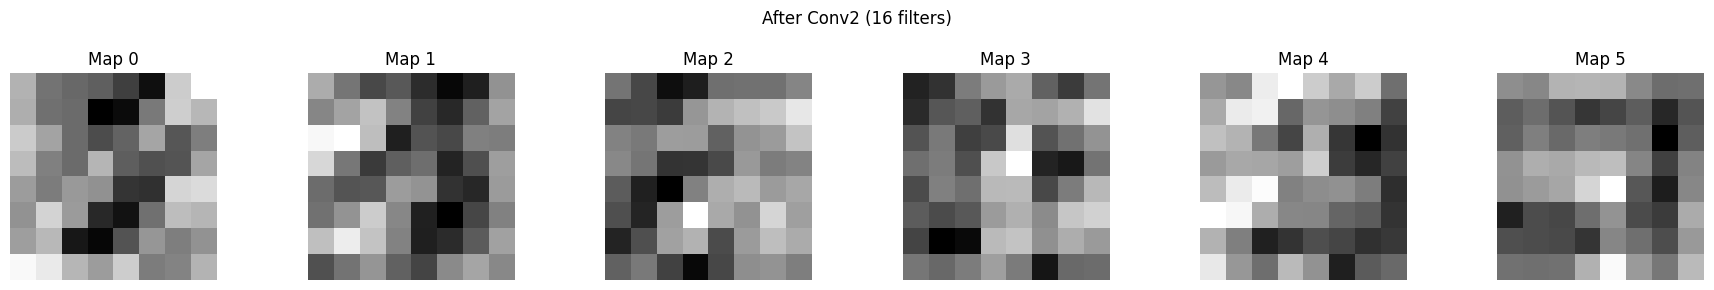

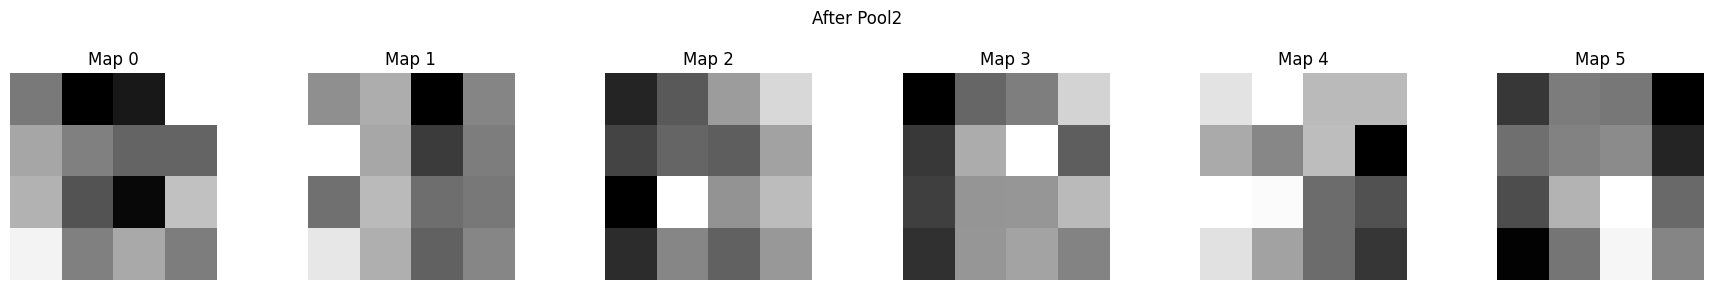

In [76]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy

sample = X_train[0:1]  # shape: (1, 1, 28, 28)

# Layer outputs
conv1_layer = Conv2d(in_channels=1, out_channels=6, kernel_size=5) # Assuming Conv2d is defined
pool1_layer = MaxPool2D(kernel_size=2, stride=2)
conv2_layer = Conv2d(in_channels=6, out_channels=16, kernel_size=5) # Assuming Conv2d is defined
pool2_layer = MaxPool2D(kernel_size=2, stride=2)


out1 = conv1_layer.forward(sample)        # C1
out2 = pool1_layer.forward(out1)          # S2
out3 = conv2_layer.forward(out2)          # C3
out4 = pool2_layer.forward(out3)          # S4


# Plot feature maps
def plot_feature_maps(tensor, title, num_maps=6):

    fig, axes = plt.subplots(1, num_maps, figsize=(num_maps * 3, 3))
    fig.suptitle(title)

    if num_maps == 1:

        axes.imshow(tensor[0, 0], cmap='gray')
        axes.set_title(f"Map 0")
        axes.axis('off')
    else:

        for i in range(num_maps):
            axes[i].imshow(tensor[0, i], cmap='gray')
            axes[i].set_title(f"Map {i}")
            axes[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

plot_feature_maps(sample, "Input Digit", num_maps=1)
plot_feature_maps(out1, "After Conv1 (6 filters)", num_maps=6)
plot_feature_maps(out2, "After Pool1", num_maps=6)
plot_feature_maps(out3, "After Conv2 (16 filters)", num_maps=6)
plot_feature_maps(out4, "After Pool2", num_maps=6)

Why 3×3 filters are commonly used instead of large ones such as 7×7

1. Parameter efficiency
  A single 7×7 filter has 49 weights per input channel, while stacking three 3×3 filters gives a similar receptive field (7×7) and reduces Memory and computation.
2. Non Linearity
  Stacking multiple 3×3 layers introduces more activation functions , allowing the network to learn more complex, hierarchical features than a single large filter could


Effects of a 1×1 filter with no height or width direction
  1. It introduces non-linearity when stacked with     activation functions.
  2.It reduces dimensionality without changing the spatial resolution.
